# Тестирование работы свёрточной нейронной сети

In [1]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
rng = np.random.default_rng(51)

## Разведочный анализ и подготовка данных

In [ ]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = load_data('../data/3. mnist.npz')

Переведение картинок в вектора

In [6]:
X_train = x_train.reshape(x_train.shape[0], 784)

In [ ]:
embed=TSNE(n_components=2,perplexity=10,learning_rate=200)#Понижение размерности для визуализации

In [11]:
X_embedded = embed.fit_transform(X_train)

In [41]:
print('Расхождение Кульбака-Лейблера после оптимизации: ', embed.kl_divergence_)

Расхождение Кульбака-Лейблера после оптимизации:  3.4723145961761475


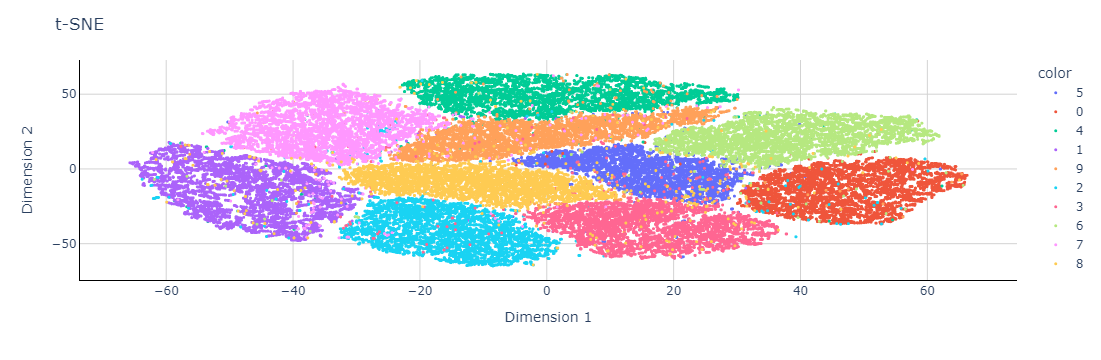

In [42]:
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1],
labels={"x": "Dimension 1","y": "Dimension 2",},
opacity=1, color=y_train.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_layout(title_text="t-SNE")
fig.update_traces(marker=dict(size=3))
fig.show()

По картинке видно, что часть классов (например, 5,8 и 9) имеет немалые пересечения между собой, что потенциально может снизить качество классификации

## Обучение и тестирование нейронной сети

In [7]:
from cv.cnn import conv

In [22]:
cnn=conv([784,5,5,10,1])#Оптимальная архитектура сети: 2 подряд слоя со сверткой с ядром 5x5, активацией и маспулингом размера 2x2 и 1 полносвязный слой

In [23]:
x_train=(x_train-np.mean(x_train))/np.std(x_train).astype('float64')#Стандартизация значений пикселей в картинке

In [ ]:
el=cnn.train(x_train,y_train,epochs=80, lr=0.00001) #Обучение сети на 80 эпохах

2.2954737793230593
2.2768802252625733
2.1781629941615757
1.957590174716805
2.001194902533898
1.8106317668059286
1.6442285031783255
1.4609434512091724
1.394062626934126
1.2023935150892602
0.9621276574553055
1.0005450301867986
1.006042540315066
1.1171304348031224
0.7008384965731539
0.9518349627641028
1.003440644223461
0.5996560802495747
0.46945832085557626
0.6947956254568669
0.4921644223042868
0.4651154739965573
0.819710669465007
0.6738135402006482
0.3745584316105587
0.5361058989410397
0.4755310979516436
0.485197121444609
0.6941754502362034
0.47243574909640884
0.8387673593885435
0.7175072636614959
0.460402753146686
0.6679681671851732
0.522310283610168
0.39690172477420504
0.7245423899723972
0.37852980309557804
0.4908628820752927
0.625225812212584
0.6077428433364149
0.33287762606580024
0.6300585873108013
0.2622950432781442
0.3886396673354478
0.39746617773929915
1.0155947844087705
0.18576609752737333
0.25098620605269045
0.6054030660682754
0.7176301718322692
0.32110747492790237
0.67034156071

Text(0.5, 1.0, 'Кривая обучения CNN')

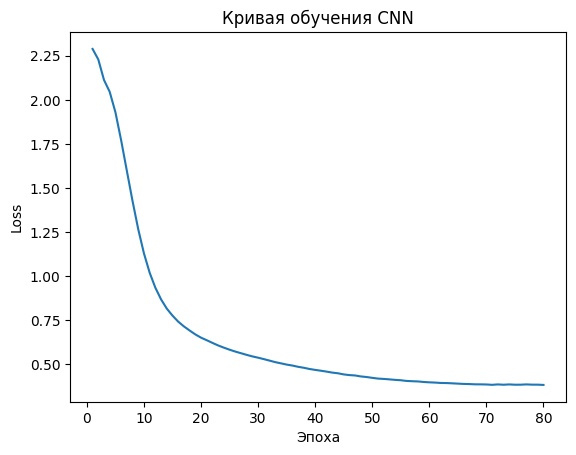

In [30]:
plt.plot([i for i in range(1,1+len(el))],el) #График обучения
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Кривая обучения CNN')

In [26]:
x_test=(x_test-np.mean(x_test))/np.std(x_test).astype('float64')#Стандартизация тестовых значений

In [36]:
y_pred=cnn.predict_classes(x_test).reshape(-1)

## Расчёт метрик качества предсказаний нейронной сети

In [37]:
pd.crosstab(y_test, y_pred)

col_0    0     1    2    3    4    5    6    7    8    9
row_0                                                   
0      953     0    4    0    0    7    9    4    3    0
1        0  1096    7    8    0    4    3    0   17    0
2       10    17  895   11   22    4   21   13   34    5
3        5    22   16  890    0   18    2   14   36    7
4        1     2   13    0  845    2   31    3   10   75
5       12     7   11   39   19  759   11    4   23    7
6       12     9   12    4    7   27  880    0    5    2
7        3    19   28   11    9    4    1  912    5   36
8        4    10    8   34   19   34   12   11  822   20
9        6    10   13   12   56   13    0   21    9  869

Можно заметить, что сеть нередко путает 4 и 9

In [38]:
from utils.metrics import accuracy, precision, recall, f_score
print('Accuracy:', accuracy(y_test, y_pred))

Accuracy: 0.8921


In [39]:
def count_metrics(y_pred,y_real): #Расчёт метрик 1 vs all
    for i in range(10):
        y_1=(np.array(y_pred)==i)
        y_2=(np.array(y_real)==i)
        print(f'Accuracy for {i}:', accuracy(y_1,y_2))
        print(f'Precision for {i}:', precision(y_1,y_2))
        print(f'Recall for {i}:', recall(y_1,y_2))
        print(f'F-score for {i}:\n', f_score(y_1,y_2))
        
        

In [40]:
count_metrics(t,y_test)

Accuracy for 0: 0.992
Precision for 0: 0.9473161033797217
Recall for 0: 0.9724489795918367
F-score for 0:
 0.9597180261832831
Accuracy for 1: 0.9865
Precision for 1: 0.9194630872483222
Recall for 1: 0.9656387665198238
F-score for 1:
 0.9419853889127632
Accuracy for 2: 0.9751
Precision for 2: 0.8887785501489573
Recall for 2: 0.8672480620155039
F-score for 2:
 0.8778813143697891
Accuracy for 3: 0.9761
Precision for 3: 0.8820614469772051
Recall for 3: 0.8811881188118812
F-score for 3:
 0.8816245666171372
Accuracy for 4: 0.9731
Precision for 4: 0.8648925281473899
Recall for 4: 0.860488798370672
F-score for 4:
 0.8626850433894844
Accuracy for 5: 0.9754
Precision for 5: 0.8704128440366973
Recall for 5: 0.850896860986547
F-score for 5:
 0.8605442176870748
Accuracy for 6: 0.9832
Precision for 6: 0.9072164948453608
Recall for 6: 0.918580375782881
F-score for 6:
 0.9128630705394191
Accuracy for 7: 0.9814
Precision for 7: 0.9287169042769857
Recall for 7: 0.8871595330739299
F-score for 7:
 0.90746